# Lane Finding Pipeline
***
## 0. Pipeline implementation

### 0.0. Load packages

In [2]:
import glob
import os
import time

import cv2
import numpy as np

%matplotlib inline

### 0.1. ImageIO

In [25]:
class ImageIO:
    """Stores basic image read/write functions."""
    
    def img_write(self, img_path, img_fname, img, write_func=cv2.imwrite):
        """Write image at specified path and filename.
        
        Args:
            img_path (str): Image path.
            img_fname (str): Image filename.
            img (img): Image file.
            write_func (func): Image write function. Defaults to cv2.imwrite.

        Returns:
            None
        """
        if not os.path.exists(img_path):
            os.makedirs(img_path)
            
        write_func(f'{img_path}/{img_fname}', img)
        return
    
    def imgs_read(self, directory):
        """Return generator that yields JPGs within a directory.
        
        Args:
            directory (str): Directory to yield images from.

        Returns:
            generator: yields tuples of JPG images within directory
                and respective filenames.
        """
        for img_fullpath in glob.glob(f'./{directory}/*.jpg'):
            img_fname = os.path.basename(img_fullpath)
            yield (cv2.imread(img_fullpath), img_fname)
            
    def imgs_pass_through(self, func, func_args, in_dir, out_dir=None):
        """Pass images through a function.
        
        Args:
            func: Function to pass images through.
            func_args: Function arguments.
            in_dir(str): Input directory.
            out_dir(str): Output directory. By default original images are replaced
                in place.
        Returns:
            None
        """
        for img, img_fname in self.imgs_read(in_dir):
            img = func(img, *func_args)
            self.img_write(in_dir if not out_dir else out_dir, img_fname, img)
        return
    
    def imgs_resize(self, resolution, in_dir, out_dir=None):
        """Resize images. If calibration images preserve the same aspect ratio
            as of the recordings, it is acceptable to downsize them.
        
        Args:
            in_dir (str): Input directory.
            resolution (tuple): Output resolution (width, height).
            out_dir (str): Output directory. By default original images are replaced
                with resized ones. If output directory is supplied, resized images
                are saved at specified directory, while preserving originals.

        Returns:
            None
        """
        self.imgs_pass_through(cv2.resize, resolution, in_dir, out_dir)
        return

### 0.2. ImageProcessor

In [4]:
class ImageProcessor:
    """Stores basic image processing functions."""
    
    def __init__(self):
        self.M = None
        self.Minv = None
        
        self.dst_quad_coords = None
        self.src_quad_coords = None
    
    ##### SOBEL THRESHOLDS #####
    
    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        """Calculate directional gradient and apply threshold"""
        gray = self.grayscale(img)
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output
    
    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):
        """Calculate gradient magnitude and apply threshold"""
        gray = self.grayscale(img)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
        return binary_output
    
    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
        """Calculate gradient direction and apply threshold"""
        gray = self.grayscale(img)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        return binary_output
    
    ##### COLOR THRESHOLDS #####
    
    def hls_l_threshold(self, img, thresh=(190, 255)):
        """Apply HLS threshold"""
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        h, l, s = cv2.split(hls)
        l = l*(255/np.max(l))
        binary = np.zeros_like(l)
        binary[(l > thresh[0]) & (l <= thresh[1])] = 1
        return binary
    
    def lab_b_threshold(self, img, thresh=(190, 255)):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(lab)
        if np.max(b) > 175:
            b = b*(255/np.max(b))
        binary = np.zeros_like(b)
        binary[((b > thresh[0]) & (b <= thresh[1]))] = 1
        return binary
    
    ##### COLOR CONVERTERS #####
    
    def grayscale(self, img):
        """Apply grayscale color conversion"""
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ##### BRIGHTNESS, CONTRAST FEATURES #####
    
    def clahe(self, img, clipLimit=1.0, tileGridSize=(8,8)):
        """Apply CLAHE - contrast limited adaptive histogram equalization"""
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        return final
    
    ##### PREPROCESSING #####
    
    def undistort(self, img, mtx, dist):
        """Undistort the image"""
        return cv2.undistort(img, mtx, dist, None, mtx)
    
    def gaussian_blur(self, img, ksize=(9,9), sigmaX=0):
        return cv2.GaussianBlur(img, ksize, sigmaX)
    
    ##### SETTINGS #####
    
    def set_perspective_transform(self, src_quad_coords, offset):
        """Compute the perspective transform and its inverse,
            given image size source points and the offset.
        
        Args:
            src_quad_coords (2D-array): Source points.
            dst_quad_coords (2D-array): Destination points.

        Returns:
            None
        """
        
        self.src_quad_coords = np.float32(src_quad_coords)
        self.dst_quad_coords = np.float32([
            [offset, self.camera.img_height],
            [self.camera.img_width - offset, self.camera.img_height],
            [self.camera.img_width - offset, 0],
            [offset, 0]
        ])
        
        self.M = cv2.getPerspectiveTransform(self.src_quad_coords, self.dst_quad_coords)
        self.Minv = cv2.getPerspectiveTransform(self.dst_quad_coords, self.src_quad_coords)
        return
    
    ##### PRE & POSTPROCESSING #####
    
    def warp(self, img, inverse=False):
        """Warp the image"""
        return cv2.warpPerspective(img,
                               self.Minv if inverse else self.M,
                               (self.camera.img_width, self.camera.img_height),
                               flags=cv2.INTER_LINEAR)
    
    ##### HELPER FUNCTIONS #####
    
    def gamma_correction(self, img, gamma=1.0):
        """Gamma correction"""
        
        lookup_table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255
            for i in np.arange(0, 256)]).astype("uint8")

        return cv2.LUT(img, lookup_table)

### 0.3. Camera

In [31]:
class Camera(ImageProcessor, ImageIO):
    
    def __init__(self):
        self.mtx = None
        self.dist = None
        
        self.img_height = None
        self.img_width = None
    
    def calibrate(self, imgs_dir, inside_corners, out_dir=None):
        """Return camera matrix and distortion coefficients tuple.
        
        Args:
            imgs_dir (str): Directory of calibration images.
            inside_corners (tuple): Number of inside corners in x and y directions.
            out_dir (str): If output directory is supplied calibration images with drawn
                chessboard corners are saved. Defaults to None.

        Returns:
            tuple: Camera matrix and distortion coefficients
        """
        
        objpoints = []
        imgpoints = []
        obj_pts = np.zeros((inside_corners[0] * inside_corners[1], 3), np.float32)
        obj_pts[:,:2] = np.mgrid[0:inside_corners[0], 0:inside_corners[1]].T.reshape(-1, 2)
        
        for img, img_fname in self.imgs_read(imgs_dir):
            if not self.img_height:
                self.set_img_size(img)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, inside_corners, None)
            if ret == True:
                objpoints.append(obj_pts)
                imgpoints.append(corners)
                if out_dir:
                    cv2.drawChessboardCorners(img, inside_corners, corners, ret)
                    self.img_write(out_dir, img_fname, img)
                
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                           (self.img_width, self.img_height),None,None)
        return
    
    def undistort_calibration_imgs(self, in_dir, out_dir):
        self.imgs_pass_through(self.undistort, (self.mtx, self.dist), in_dir, out_dir)
        return
        
    
    def set_img_size(self, img):
        """Set image height and width"""
        self.img_height, self.img_width = img.shape[:2]
        return

### 0.4. Line

In [ ]:
class Line:
    
    def __init__(self):
        self.x = None
        self.y = None
        
        self.fit = None
        self.fitx = None
        
        self.fit_found = False

### 0.5. Image

In [ ]:
class Image:
    def __init__(self, image):
        self.origin = image
        self.undistorted = None
        self.grayscale = None

### 0.6. Lane

In [ ]:
class LaneFindingPipeline(ImageProcessor):

    def __init__(self):
        self.histogram = None
        
        self.img_height = None
        self.img_width = None
        
        self.l_line = Line()
        self.r_line = Line()
        
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        self.timing_distortion_step = 0
        self.timing_clahe_step = 0
        self.timing_threshold_step = 0
        self.timing_warp_step = 0
        self.timing_fit_step = 0
        self.timing_draw_step = 0
        
    def set_camera(self, camera):
        self.camera = camera
        self.ploty = np.linspace(0, self.camera.img_height-1, self.camera.img_height)
        
    def combined_binary(self, img):
        l_binary = self.hls_l_threshold(np.copy(img))
        b_binary = self.lab_b_threshold(np.copy(img))
        gradx = self.abs_sobel_thresh(np.copy(img), orient='x', sobel_kernel=15, thresh=(20, 100))#
        grady = self.abs_sobel_thresh(np.copy(img), orient='y', sobel_kernel=15, thresh=(4, 20))
        mag_binary = self.mag_thresh(np.copy(img), sobel_kernel=15, thresh=(20, 100))
        #dir_binary = self.dir_threshold(np.copy(img), sobel_kernel=15, thresh=(0.7, 1.4))#

        combined = np.zeros_like(img)
        combined[(b_binary == 1) | (l_binary == 1)] = 1
        return (combined*255).astype(np.uint8)
    
    def find_lane_pixels(self, binary_warped):
        self.histogram = np.sum(binary_warped[self.camera.img_height//2:,:], axis=0)
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        midpoint = np.int(self.histogram.shape[0]//2)
        leftx_base = np.argmax(self.histogram[:midpoint])
        rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint

        nwindows = 9
        margin = 100
        minpix = 50

        window_height = np.int(self.camera.img_height//nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []
        
        for window in range(nwindows):
            win_y_low = self.camera.img_height - (window+1)*window_height
            win_y_high = self.camera.img_height - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass
        
        self.l_line.x = nonzerox[left_lane_inds]
        self.l_line.y = nonzeroy[left_lane_inds] 
        self.r_line.x = nonzerox[right_lane_inds]
        self.r_line.y = nonzeroy[right_lane_inds]

        return self.l_line.x, self.l_line.y, self.r_line.x, self.r_line.y
    
    def fit_polynomial(self, binary_warped):
        leftx, lefty, rightx, righty = self.find_lane_pixels(binary_warped)

        self.l_line.fit = np.polyfit(lefty, leftx, 2)
        self.l_line.fit_found = True
        self.r_line.fit = np.polyfit(righty, rightx, 2)
        self.r_line.fit_found = True

        try:
            self.l_line.fitx = self.l_line.fit[0]*self.ploty**2 + self.l_line.fit[1]*self.ploty + self.l_line.fit[2]
            self.r_line.fitx = self.r_line.fit[0]*self.ploty**2 + self.r_line.fit[1]*self.ploty + self.r_line.fit[2]
        except TypeError:
            print('The function failed to fit a line!')
            self.l_line.fitx = 1*self.ploty**2 + 1*self.ploty
            self.r_line.fitx = 1*self.ploty**2 + 1*self.ploty
            
        return
    
    def search_around_poly(self, binary_warped):
        margin = 100

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (self.l_line.fit[0]*(nonzeroy**2) + self.l_line.fit[1]*nonzeroy + 
                        self.l_line.fit[2] - margin)) & (nonzerox < (self.l_line.fit[0]*(nonzeroy**2) + 
                        self.l_line.fit[1]*nonzeroy + self.l_line.fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.r_line.fit[0]*(nonzeroy**2) + self.r_line.fit[1]*nonzeroy + 
                        self.r_line.fit[2] - margin)) & (nonzerox < (self.r_line.fit[0]*(nonzeroy**2) + 
                        self.r_line.fit[1]*nonzeroy + self.r_line.fit[2] + margin)))

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        self.l_line.fitx = self.l_line.fit[0]*self.ploty**2 + self.l_line.fit[1]*self.ploty + self.l_line.fit[2]
        self.r_line.fitx = self.r_line.fit[0]*self.ploty**2 + self.r_line.fit[1]*self.ploty + self.r_line.fit[2]
        
        self.l_line.fit = np.polyfit(lefty, leftx, 2)
        self.r_line.fit = np.polyfit(righty, rightx, 2)
        
        return
    
    def measure_curvature_real(self):
        '''
        Calculate the curvature of polynomial functions in meters.
        '''
        
        left_fit_cr = np.polyfit(self.l_line.y*self.ym_per_pix, self.l_line.x*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.r_line.y*self.ym_per_pix, self.r_line.x*self.xm_per_pix, 2)

        y_eval = np.max(self.ploty)

        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_curverad, right_curverad
    
    def measure_dist_to_lane_center(self):
        '''
        Calculate the distance to center of the lane in meters.
        '''
        camera_center_position = self.camera.img_width/2
        
        l_fit_x_int = self.l_line.fit[0]*self.camera.img_height**2 \
            + self.l_line.fit[1]*self.camera.img_height \
            + self.l_line.fit[2]
        r_fit_x_int = self.r_line.fit[0]*self.camera.img_height**2 \
            + self.r_line.fit[1]*self.camera.img_height \
            + self.r_line.fit[2]
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        dist_to_center = (camera_center_position - lane_center_position) * self.xm_per_pix
        
        return dist_to_center
    
    def draw_lane(self):
        img_origin = np.copy(self.img)
        zeros = np.zeros_like(self.img_copy[2]).astype(np.uint8)
        lane_mask = np.dstack((zeros, zeros, zeros))
        
        l_line_pts = np.array([np.transpose(np.vstack([self.l_line.fitx, self.ploty]))])
        r_line_pts = np.array([np.flipud(np.transpose(np.vstack([self.r_line.fitx, self.ploty])))])
        pts = np.hstack((l_line_pts, r_line_pts))

        cv2.fillPoly(lane_mask, np.int_([pts]), (204,255,204))
        cv2.polylines(lane_mask, np.int32([l_line_pts]), isClosed=False, color=(0,255,0), thickness=20)
        cv2.polylines(lane_mask, np.int32([r_line_pts]), isClosed=False, color=(0,255,0), thickness=20)
        
        lane_mask_unwarped = self.warp(lane_mask, True)
        result = cv2.addWeighted(img_origin, 1, lane_mask_unwarped, 0.5, 0)
        return result
    
    def draw_meta(self):
        img_origin = np.copy(self.img_copy)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        avg_lane_rad = np.sum(self.measure_curvature_real())/2
        lane_rad_line = f'Averaged lane radius: {avg_lane_rad:.2f} m'
        cv2.putText(img_origin, lane_rad_line, (30,50), font, 1, (204,255,204), 2, cv2.LINE_AA)
        
        car_pos = self.measure_dist_to_lane_center()
        car_pos_line = f'Position relative to center: {car_pos:.2f} m'
        cv2.putText(img_origin, car_pos_line, (30,100), font, 1, (204,255,204), 2, cv2.LINE_AA)
        return img_origin
    
    def run(self, img, save):
        #self.image = Image(img)
        self.img = img
        
        t0 = time.time()
        #self.image.undistorted = self.undistort(np.copy(self.origin), self.camera.mtx, self.camera.dist)
        self.img_copy = np.copy(img)
        self.img_copy = self.undistort(self.img_copy, self.camera.mtx, self.camera.dist)
        t1 = time.time()
        self.img_copy = self.adjust_gamma(self.img_copy, 0.1)
        #plt.imshow(cv2.cvtColor(self.img_copy, cv2.COLOR_BGR2RGB))
        self.img_copy = self.warp(self.img_copy)
        
        t2 = time.time()
        #self.img_copy = self.gaussian_blur(self.img_copy)
  
        t3 = time.time()
        self.img_copy = self.combined_binary(self.img_copy)
        plt.imshow(self.img_copy)

        t4 = time.time()
        
        if not self.l_line.fit_found or not self.r_line.fit_found:
            self.fit_polynomial(self.img_copy)
        else:
            self.search_around_poly(self.img_copy)
        t5 = time.time()
        self.img_copy = self.draw_lane()
        self.img_copy = self.draw_meta()
        t6 = time.time()
        
        self.timing_distortion_step += t1-t0
        self.timing_clahe_step += t3-t2
        self.timing_threshold_step += t4-t3
        self.timing_warp_step += t2-t1
        self.timing_fit_step += t5-t4
        self.timing_draw_step += t6-t5
        
        return self.img_copy

### 0.7. Plotting helper functions

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def two_imgs_side_by_side(img_fname, img1_path, title1, img2_path, title2, fontsize=30):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(cv2.imread(f'{img1_path}/{img_fname}'))
    ax1.set_title(title1, fontsize=fontsize)
    ax2.imshow(cv2.imread(f'{img2_path}/{img_fname}'))
    ax2.set_title(title2, fontsize=fontsize)

## 1. Pipeline setup - project test images & videos
### 1.0. Camera calibration

In [32]:
CAM_0 = Camera()
CAM_0.calibrate('camera_cal', (9,6), out_dir='output_images/chessboard_corners')

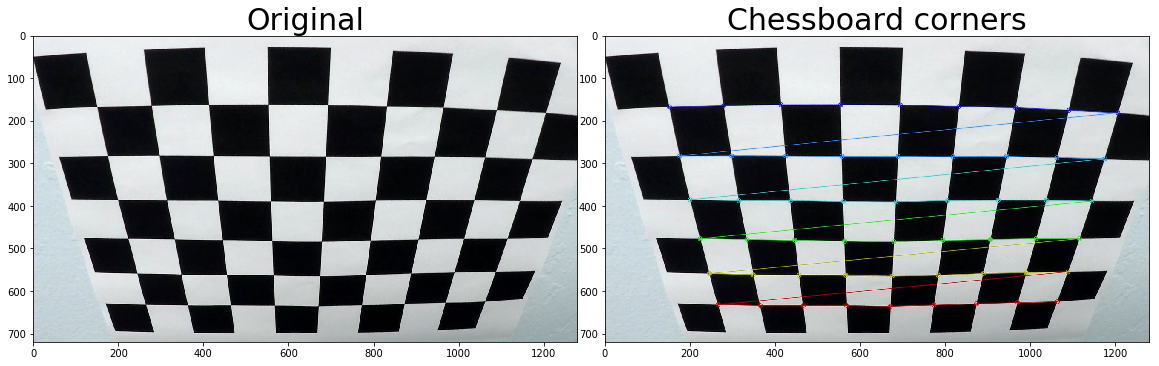

In [35]:
two_imgs_side_by_side(
    'calibration2.jpg',
    'camera_cal', 'Original',
    'output_images/chessboard_corners', 'Chessboard corners'
)

In [34]:
CAM_0.undistort_calibration_imgs('camera_cal', 'output_images/cal_undistorted')

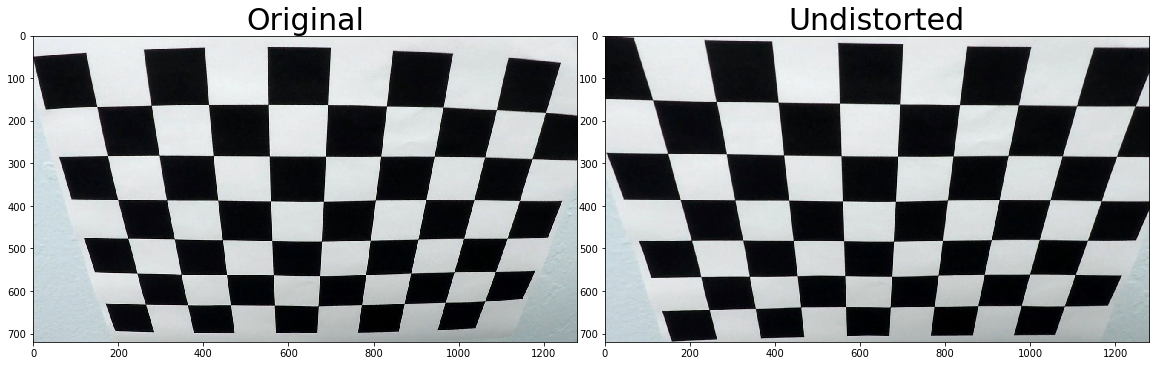

In [36]:
two_imgs_side_by_side(
    'calibration2.jpg',
    'camera_cal', 'Original',
    'output_images/cal_undistorted', 'Undistorted'
)

### 1.1. LaneFindingPipeline setup
#### 1.1.0. LFP init & input of calibrated camera object

In [51]:
LFP_0 = LaneFindingPipeline()
LFP_0.set_camera(CAM_0)

NameError: name 'LaneFindingPipeline' is not defined

#### 2.1.1. Setting perspective transforms

In [ ]:
LFP_0.set_perspective_transform([[180, 685], [1100, 685], [694, 450], [586, 450]], 450)

## 2. Pipeline setup - private test videos
### 2.0. Resize calibration images

In [26]:
# Samsung Galaxy S8 doesn't allow to lower resolution to 1280x720.
# Default resolution is 4032x2268. Since both resolutions aspect ratio is 16:9,
# it is acceptable to downsize calibration images.
# Selected resolution matches video defaults - HD (1280x720)
CAM_1 = Camera()
CAM_1.imgs_resize((1280, 720), 'galaxy_s8/camera_cal/origin', out_dir='galaxy_s8/camera_cal/resized')

### 2.1. Camera calibration

In [6]:
CAM_1.calibrate('galaxy_s8/camera_cal/resized', (9,6), out_dir='galaxy_s8/camera_cal/chessboard_corners')

### 2.1. LaneFindingPipeline setup
#### 2.1.0. LFP init & input of calibrated camera object

In [ ]:
LFP_1 = LaneFindingPipeline()
LFP_1.set_camera(CAM_1)

#### 2.1.1. Setting perspective transforms

In [ ]:
#LFP.set_perspective_transform([[180, 685], [1100, 685], [694, 450], [586, 450]], 450)

In [ ]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip